In [32]:
from sympy import *
# Use dot for derivative
# https://stackoverflow.com/questions/25346132/is-it-possible-to-implement-newtons-dot-notation-or-lagranges-prime-notation
from sympy.physics.mechanics import dynamicsymbols, init_vprinting, vlatex
init_vprinting()

In [33]:
g = symbols('g', real=True)
t = Symbol('t')
m, I, m_w, I_w, r, h = symbols('m I m_w I_w r h', real=True)
x, y, x_w, y_w, theta, phi = dynamicsymbols('x y x_w y_w theta phi')
theta_dot = diff(theta, t)
theta_ddot = diff(theta_dot, t)
phi_dot = diff(phi, t)
phi_ddot = diff(phi_dot, t)

In [34]:
x_w_dot = r*(theta_dot + phi_dot)
y_w_dot = 0

In [35]:
x_dot = x_w_dot + h*theta_dot*cos(theta)
y_dot = -h*theta_dot*sin(theta)

In [36]:
T_translation_wheel = Rational(1,2) * m_w * x_w_dot**2
T_translation_wheel

In [37]:
T_translation_body = Rational(1,2) * m * simplify(expand((x_dot**2 + y_dot**2), trig=true))
T_translation_body

In [38]:
T_translation = T_translation_body + T_translation_wheel
T_translation

In [39]:
T_rotation = Rational(1,2) * I * theta_dot**2 + Rational(1,2) * I_w * (theta_dot + phi_dot)**2
T_rotation

In [40]:
T = T_translation + T_rotation
T

In [41]:
print(vlatex(T))

\frac{I \dot{\theta}^{2}}{2} + \frac{I_{w} \left(\dot{\phi} + \dot{\theta}\right)^{2}}{2} + \frac{m \left(h^{2} \dot{\theta}^{2} + 2 h r \cos{\left(\theta \right)} \dot{\phi} \dot{\theta} + 2 h r \cos{\left(\theta \right)} \dot{\theta}^{2} + r^{2} \dot{\phi}^{2} + 2 r^{2} \dot{\phi} \dot{\theta} + r^{2} \dot{\theta}^{2}\right)}{2} + \frac{m_{w} r^{2} \left(\dot{\phi} + \dot{\theta}\right)^{2}}{2}


In [42]:
U = m*g*(r + h*cos(theta))

In [43]:
L = T - U
L

In [44]:
equation = collect(
    simplify(diff(diff(L, theta_dot), t) - diff(L, theta)),
    [theta, phi, theta_dot, phi_dot, theta_ddot, phi_ddot]
)
equation

In [45]:
print(vlatex(equation))

- g h m \sin{\left(\theta \right)} - h m r \sin{\left(\theta \right)} \dot{\theta}^{2} + \left(I_{w} + h m r \cos{\left(\theta \right)} + m r^{2} + m_{w} r^{2}\right) \ddot{\phi} + \left(I + I_{w} + h^{2} m + 2 h m r \cos{\left(\theta \right)} + m r^{2} + m_{w} r^{2}\right) \ddot{\theta}


In [46]:
equation_lin = equation.subs([(sin(theta), theta), (cos(theta), 1), (theta_dot**2, 0)])
equation_lin

In [47]:
print(vlatex(equation_lin))

- g h m \theta + \left(I_{w} + h m r + m r^{2} + m_{w} r^{2}\right) \ddot{\phi} + \left(I + I_{w} + h^{2} m + 2 h m r + m r^{2} + m_{w} r^{2}\right) \ddot{\theta}


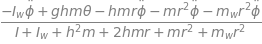

In [48]:
theta_ddot_eq = solve(equation_lin, theta_ddot)[0]
theta_ddot_eq

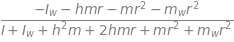

In [49]:
b = diff(theta_ddot_eq, phi_ddot)
b

In [50]:
print(vlatex(b))

\frac{- I_{w} - h m r - m r^{2} - m_{w} r^{2}}{I + I_{w} + h^{2} m + 2 h m r + m r^{2} + m_{w} r^{2}}


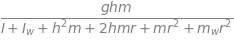

In [51]:
a = diff(theta_ddot_eq, theta)
a

In [52]:
print(vlatex(a))

\frac{g h m}{I + I_{w} + h^{2} m + 2 h m r + m r^{2} + m_{w} r^{2}}


In [53]:
numeric_params = {
    m: 181.731, I: 61096.991,
    r: 60, m_w: 21.994, I_w: 13319.524,
    h: 14.924,
    g: 9800
}
a_num = a.evalf(subs=numeric_params)
b_num = b.evalf(subs=numeric_params)
print('a =', a_num)
print('b =', b_num)

a = 22.6443895687399
b = -0.774824387837912


In [54]:
import numpy as np
import control

In [55]:
A_mat = np.array([
    [0, 1, 0],
    [float(a_num), 0, 0],
    [0, 0, 0]
])
B_mat = np.array([
    [0],
    [float(b_num)],
    [1]
])

In [56]:
np.linalg.matrix_rank(control.ctrb(A_mat, B_mat))

3

In [57]:
#Q_mat = np.diag([1.0, 0.1, 1.0])
#R_mat = np.diag([0.1])
Q_mat = np.diag([100.0, 50.0, 1.0])
R_mat = np.diag([0.01])
K, S, E = control.lqr(A_mat, B_mat, Q_mat, R_mat)
print('K =', K)
print('E =', E)

K = [[-280.74261026  -89.66049857  -10.        ]]
E = [-56.06732134+0.j          -1.70190979+1.06877911j
  -1.70190979-1.06877911j]


In [58]:
import matplotlib.pyplot as plt

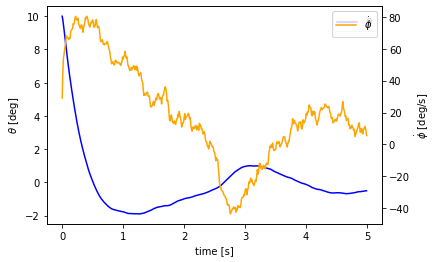

In [59]:
state = np.array([10 * np.pi / 180, 0.0, 0.0])
dt = 0.01
t_array = np.arange(0, 5, dt)
theta_array = np.empty_like(t_array)
phi_dot_array = np.empty_like(t_array)
for i, t in enumerate(t_array):
    u = -K @ state
    noise = np.random.multivariate_normal(mean=[0, 0, 0], cov=np.diag([0, 0.1, 10.0]))
    diff_state = A_mat @ state + B_mat @ u + noise
    state[:] = state + dt * diff_state
    theta_array[i] = state[0]
    phi_dot_array[i] = state[2]

plt.plot(t_array, theta_array * 180 / np.pi, label="$\\theta$", color='blue')
plt.xlabel("time [s]")
plt.ylabel("$\\theta$ [deg]")
plt.legend()

ax2 = plt.twinx()
ax2.plot(t_array, phi_dot_array * 180 / np.pi, label="$\\dot{\\phi}$", color='orange')
ax2.set_ylabel("$\\dot{\\phi}$ [deg/s]")
ax2.legend()

plt.show()

In [60]:
theta_ddot_eq_nonlin = solve(equation, theta_ddot)[0]
theta_ddot_func = lambdify([theta, theta_dot, phi_ddot], theta_ddot_eq_nonlin.evalf(subs=numeric_params))

def diff_state_func(state, u):
    return np.array([state[1], theta_ddot_func(state[0], state[1], u[0]), u[0]])

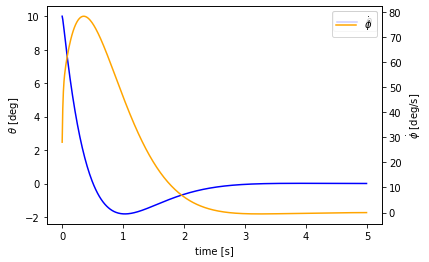

In [61]:
state = np.array([10 * np.pi / 180, 0.0, 0.0])
dt = 0.01
t_array = np.arange(0, 5, dt)
theta_array = np.empty_like(t_array)
phi_dot_array = np.empty_like(t_array)
for i, t in enumerate(t_array):
    u = -K @ state
    diff_state = diff_state_func(state, u)
    state[:] = state + dt * diff_state
    theta_array[i] = state[0]
    phi_dot_array[i] = state[2]

plt.plot(t_array, theta_array * 180 / np.pi, label="$\\theta$", color='blue')
plt.xlabel("time [s]")
plt.ylabel("$\\theta$ [deg]")
plt.legend()

ax2 = plt.twinx()
ax2.plot(t_array, phi_dot_array * 180 / np.pi, label="$\\dot{\\phi}$", color='orange')
ax2.set_ylabel("$\\dot{\\phi}$ [deg/s]")
ax2.legend()

plt.show()

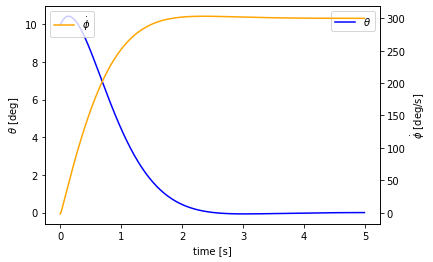

In [62]:
state_ref = np.array([0.0, 0.0, 300 * np.pi / 180])
u_ref = np.linalg.pinv(B_mat) @ A_mat @ state_ref

state = np.array([10 * np.pi / 180, 0.0, 0.0])
dt = 0.01
t_array = np.arange(0, 5, dt)
theta_array = np.empty_like(t_array)
phi_dot_array = np.empty_like(t_array)
for i, t in enumerate(t_array):
    # control
    u = -K @ (state - state_ref) + u_ref
    # simulation
    diff_state = diff_state_func(state, u)
    state[:] = state + dt * diff_state
    # logging
    theta_array[i] = state[0]
    phi_dot_array[i] = state[2]

plt.plot(t_array, theta_array * 180 / np.pi, label="$\\theta$", color='blue')
plt.xlabel("time [s]")
plt.ylabel("$\\theta$ [deg]")
plt.legend()

ax2 = plt.twinx()
ax2.plot(t_array, phi_dot_array * 180 / np.pi, label="$\\dot{\\phi}$", color='orange')
ax2.set_ylabel("$\\dot{\\phi}$ [deg/s]")
ax2.legend()

plt.show()

In [63]:
np.linalg.pinv(B_mat) @ A_mat

array([[-10.96347314,   0.        ,   0.        ]])